<a href="https://colab.research.google.com/github/noelmtv/Colab-Learning/blob/main/Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries#
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
!pip install fredapi



In [2]:
#define the list of tickers#
tickers = [
    "ACRE", "NYMT", "HST","RHP","ARE","SPG","MITT","IIPR","DX","CIM", "TWO", "NLY", "AGNC", "RC", "ARR"
]


In [3]:
#SET THE END DATE TO TODAY#
end_date = datetime.today()

In [4]:
#Set start date#
start_date = end_date - timedelta(days=5*365)
print(start_date)

2020-07-03 05:26:03.936623


In [5]:
#download adjusted close prices#
#This is done because you dont want to underweight a stock that pays out dividends#
adj_close_df = pd.DataFrame()
print(adj_close_df.columns)

RangeIndex(start=0, stop=0, step=1)


In [6]:
# Download the prices for each ticker#
#yFinance has by default adjusted Open/High/Low/Close, hence no need to specify 'Adj Close'
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data["Close"]

/tmp/ipython-input-6-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-6-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-6-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-6-1957566553.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-inp

In [7]:
print(adj_close_df)

                ACRE      NYMT        HST         RHP         ARE         SPG  \
Date                                                                            
2020-07-06  4.586032  5.525373   9.556283   29.985645  136.468445   51.276340   
2020-07-07  4.462809  5.197782   9.240864   28.082504  132.981979   49.044674   
2020-07-08  4.452094  5.394335   9.147093   28.100374  133.205582   48.881023   
2020-07-09  4.296726  5.110423   8.959550   27.564280  134.364944   46.308327   
2020-07-10  4.473525  5.306979   9.240864   28.100374  133.172455   48.554684   
...              ...       ...        ...         ...         ...         ...   
2025-06-25  4.789696  6.460000  15.303299   97.689781   72.354424  157.399994   
2025-06-26  4.847870  6.630000  15.510634   98.965034   72.874886  160.600006   
2025-06-27  4.780000  6.650000  15.560000   99.400002   72.050003  160.500000   
2025-06-30  4.770000  6.700000  15.360000   98.669998   72.629997  160.759995   
2025-07-01  4.800000  6.7600

**Step 3: Calculate the Lognormal Returns**

In [8]:
#Calculate the Lognormal returns for each ticker#
#Use lognormal because the returns are additive#
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [9]:
#drop missing values#
log_returns = log_returns.dropna()

**Step 4: Calculate the Covariance Matrix**

In [10]:
#helps us calculate standard deviation/risk in the most optimal way possible#
# MULTIPLY BY 252 TO ANNUALISE THE DAILY RETURNS#

cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          ACRE      NYMT       HST       RHP       ARE       SPG      MITT  \
ACRE  0.125667  0.083137  0.065252  0.065619  0.047547  0.062104  0.078645   
NYMT  0.083137  0.125002  0.066323  0.068051  0.049119  0.063022  0.087716   
HST   0.065252  0.066323  0.125772  0.111529  0.039526  0.082299  0.058114   
RHP   0.065619  0.068051  0.111529  0.144857  0.040760  0.086012  0.061224   
ARE   0.047547  0.049119  0.039526  0.040760  0.079261  0.045311  0.039102   
SPG   0.062104  0.063022  0.082299  0.086012  0.045311  0.108866  0.061768   
MITT  0.078645  0.087716  0.058114  0.061224  0.039102  0.061768  0.180757   
IIPR  0.055613  0.057015  0.045526  0.053902  0.055401  0.048817  0.055034   
DX    0.053827  0.059421  0.036941  0.036372  0.033139  0.036113  0.058554   
CIM   0.085134  0.096050  0.060420  0.062257  0.049868  0.062873  0.092473   
TWO   0.072834  0.080303  0.059413  0.059662  0.040885  0.057443  0.075114   
NLY   0.058072  0.065129  0.041979  0.042191  0.039644  0.042847

**Section 5: Define portfolio Performance Metrics**

In [11]:
#calculate the portfolio standard deviation#
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [12]:
#Calculate Expected Returns using historical returns#
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [13]:
# calculate the Sharpe Ratio

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)


In [14]:
# Get and define your FRED API key from secrets tab in Colab
from google.colab import userdata
fred_api_key = userdata.get('fred_api_key')

# Get the risk free rate
from fredapi import Fred
fred = Fred(api_key = fred_api_key)
ten_year_treasury_rate = fred.get_series('GS10')/100

#Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)


0.0438


In [15]:
#Define the function to minimize (Negative Sharpe Ratio)
# In the case of scipy, there is no direct method to find the maximum value of a function so you gotta flip it.

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

    print(neg_sharpe_ratio)

In [16]:
#Set the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0,0.5) for _ in range(len(tickers))]

In [17]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]


In [18]:
#optimize the weights to maximise the sharpe ratio

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                             method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_results.x

# Print the optimized weights
print("Optimized Weights:")
print(optimized_weights)

Optimized Weights:
[2.91433544e-16 6.93889390e-17 0.00000000e+00 5.00000000e-01
 0.00000000e+00 5.00000000e-01 2.77555756e-17 0.00000000e+00
 1.94289029e-16 2.77555756e-17 0.00000000e+00 1.66533454e-16
 2.08166817e-16 0.00000000e+00 4.16333634e-17]


**Analyse the optimal portfolio**

In [19]:
# Display the analytics of the optimal portfolio

for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimized_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal Portfolio Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

ACRE: 0.0000
NYMT: 0.0000
HST: 0.0000
RHP: 0.5000
ARE: 0.0000
SPG: 0.5000
MITT: 0.0000
IIPR: 0.0000
DX: 0.0000
CIM: 0.0000
TWO: 0.0000
NLY: 0.0000
AGNC: 0.0000
RC: 0.0000
ARR: 0.0000

Optimal Portfolio Return: 0.2396
Optimal Portfolio Volatility: 0.3262
Optimal Sharpe Ratio: 0.6003


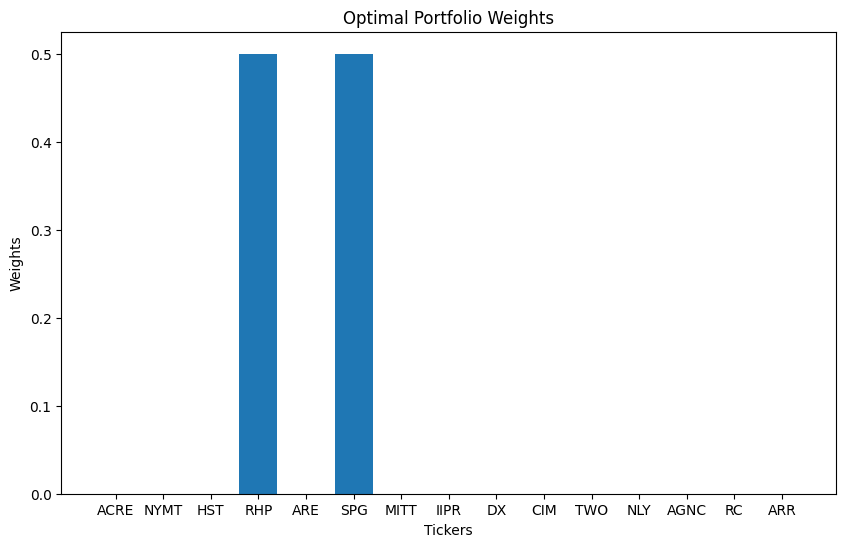

In [20]:
#display the final portfolio in a plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights')
plt.show()